# Demand Forecasting: LightGBM vs SARIMAX

## Overview
This notebook implements and compares two forecasting approaches:
- **LightGBM**: ML-based approach with category-specific models
- **SARIMAX**: Time series approach with exogenous variables

## Key Features
- **Custom RMSLE metric** for accurate demand forecasting evaluation
- **GroupKFold cross-validation** to prevent data leakage
- **Holiday features** (fixed) for better seasonal predictions
- **Comprehensive analysis** with visualizations and business insights

## Expected Outcomes
- Category-specific RMSLE performance metrics
- Feature importance analysis
- Holiday vs normal period performance comparison
- Production-ready forecasting models


# 1. Setup & Data Loading



In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_squared_log_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
# TimeSeriesSplit for cross-validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
from catboost import CatBoostRegressor

# Custom utilities
from model_utils import plot_prediction_dashboard
from my_functions import *

# Import time series libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

# Configure display settings
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")


All libraries imported successfully!


In [2]:
# This data comes from notebook 03 with engineered features
data = pd.read_csv('../outputs/demand_data_pp.csv')
print("Data loaded successfully!")

data.describe()

Data loaded successfully!


,price,demand
count,2.359954e+07,2.359954e+07
mean,1.450314e+02,4.704456e-03
std,2.454949e+02,8.556197e-02
min,8.500000e-01,0.000000e+00
25%,3.990000e+01,0.000000e+00
50%,7.900000e+01,0.000000e+00
75%,1.549000e+02,0.000000e+00
max,6.735000e+03,2.500000e+01


In [3]:
# Check data structure
print(f"Data shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print(f"Date range: {data['order_date'].min()} to {data['order_date'].max()}")

# Check for missing values
print(f"\nMissing values:")
print(data.isnull().sum())

# Check data types
print(f"\nData types:")
print(data.dtypes)

# Sample data
print(f"\nSample data:")
data.head()


Data shape: (23599542, 5)
Columns: ['order_date', 'product_id', 'categ', 'price', 'demand']
Date range: 2016-09-04 to 2018-09-03

Missing values:
order_date    0
product_id    0
categ         0
price         0
demand        0
dtype: int64

Data types:
order_date     object
product_id     object
categ          object
price         float64
demand        float64
dtype: object

Sample data:


,order_date,product_id,categ,price,demand
0,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,1.0
1,2016-09-05,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
2,2016-09-06,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
3,2016-09-07,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
4,2016-09-08,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0


# 3. Modeling Strategy: Product-Level → Category-Level

Our approach uses category-specific models to handle the diversity in demand patterns across different product categories.


### Why We Moved from Product-Level to Category-Level Aggregation

### **The previous approach (Product-Week Level)**
- **Granularity**: Individual products by week
- **Dataset size**: 3,426,768 rows across 71 categories
- **Challenges encountered**:
  - **Extreme sparsity**: Many products have zero demand for extended periods
  - **Noise dominance**: Individual product demand is highly volatile and unpredictable
  - **Model instability**: Sparse data leads to poor model performance
  - **Computational complexity**: Training separate models for thousands of products


### **New approach (Category-Week Level)**
- **Granularity**: Product categories by week
- **Dataset size**: 7,384 rows across 71 categories
- **Key advantages**:
  - **Reduced sparsity**: Category totals are more consistent than individual products
  - **Better signal-to-noise ratio**: Aggregation smooths out individual product volatility
  - **Business alignment**: Category-level planning is standard in retail operations
  - **Model stability**: More data points per category for robust model training


In [4]:

category_data = improved_data_preprocessing(data)

output_file = '../outputs/data_to_train.csv'
category_data.to_csv(output_file, index=False)
# Sample data
print(f"\nSample data:")
category_data.head()
category_data.describe().T

🚀 IMPROVED CATEGORY-LEVEL FEATURE ENGINEERING PIPELINE

 FEATURE ENGINEERING COMPLETE!
 Final dataset: 7,384 rows × 28 columns

Sample data:


,count,mean,min,25%,50%,75%,max,std
week,7384,2017-08-24 12:00:00,2016-08-29 00:00:00,2017-02-25 06:00:00,2017-08-24 12:00:00,2018-02-20 18:00:00,2018-08-20 00:00:00,NaN
demand,7384.0,15.017876,0.0,0.0,1.0,11.0,438.0,33.415042
price,7384.0,169.242185,35.327857,85.415501,134.791235,183.16009,1366.261327,169.703497
active_products,7384.0,455.323944,1.0,31.0,95.0,517.0,3029.0,737.385845
lag_1w,7384.0,14.856988,0.0,0.0,1.0,10.0,438.0,33.32972
lag_2w,7384.0,14.580309,0.0,0.0,1.0,10.0,438.0,32.950964
lag_4w,7384.0,13.966414,0.0,0.0,1.0,9.0,438.0,32.066413
rolling_mean_4w,7384.0,14.420538,0.0,0.0,1.5,9.75,251.5,31.578954
rolling_std_4w,7384.0,4.118196,0.0,0.0,1.258306,4.041452,149.810992,9.013293
simple_trend,7384.0,0.254164,-103.25,-0.25,0.0,0.5,95.75,6.150576


In [5]:
# Save data for next usage
category_data = pd.read_csv('../outputs/data_to_train.csv')
category_data['week'] = pd.to_datetime(category_data['week'])
category_data.describe().T


,count,mean,min,25%,50%,75%,max,std
week,7384,2017-08-24 12:00:00,2016-08-29 00:00:00,2017-02-25 06:00:00,2017-08-24 12:00:00,2018-02-20 18:00:00,2018-08-20 00:00:00,NaN
demand,7384.0,15.017876,0.0,0.0,1.0,11.0,438.0,33.415042
price,7384.0,169.242185,35.327857,85.415501,134.791235,183.16009,1366.261327,169.703497
active_products,7384.0,455.323944,1.0,31.0,95.0,517.0,3029.0,737.385845
lag_1w,7384.0,14.856988,0.0,0.0,1.0,10.0,438.0,33.32972
lag_2w,7384.0,14.580309,0.0,0.0,1.0,10.0,438.0,32.950964
lag_4w,7384.0,13.966414,0.0,0.0,1.0,9.0,438.0,32.066413
rolling_mean_4w,7384.0,14.420538,0.0,0.0,1.5,9.75,251.5,31.578954
rolling_std_4w,7384.0,4.118196,0.0,0.0,1.258306,4.041452,149.810992,9.013293
simple_trend,7384.0,0.254164,-103.25,-0.25,0.0,0.5,95.75,6.150576


## LightGBM Training Execution

- **One model per category** to capture category-specific patterns
- **Target**: 2-week ahead demand forecast
- **Data preprocessing**: Remove sparse rows (zero demand + zero lags)
- **Cross-validation**: GroupKFold by product_id to prevent leakage
- **Evaluation**: Custom RMSLE metric for accurate performance measurement
  
Feature selection and model training across all product categories. Uses engineered features including the fixed holiday features for improved seasonal forecasting.


In [6]:
features_to_train = ['price', 'active_products', 'lag_1w',
       'lag_2w', 'lag_4w', 'rolling_mean_4w', 'rolling_std_4w', 'simple_trend',
       'demand_growth', 'price_change', 'price_change_pct', 'price_volatility',
       'price_vs_market', 'active_products_change', 'month', 'weekofyear',
       'quarter', 'days_to_christmas', 'is_holiday_season', 'is_summer',
       'is_back_to_school', 'market_share', 'demand_rank']

In [7]:
print("🚀 TRAINING GLOBAL LightGBM MODEL ON WEEKLY DATA WITH CROSS-VALIDATION")
print("=" * 60)

# Prepare features and target
X = category_data[features_to_train]
y = category_data['target_2w']

tscv = TimeSeriesSplit(n_splits=3)
r2_scores = []
mae_scores = []
rmsle_scores = []

print("Running TimeSeries Cross-Validation...")
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_X, test_X = X.iloc[train_idx], X.iloc[test_idx]
    train_y, test_y = y.iloc[train_idx], y.iloc[test_idx]

    # Train category-specific model for this fold
    lgb_glogal_model = LGBMRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    lgb_glogal_model.fit(train_X, train_y)
    y_pred = lgb_glogal_model.predict(test_X)

    # Evaluate and store scores for this fold
    r2 = r2_score(test_y, y_pred)
    mae = mean_absolute_error(test_y, y_pred)
    rmsle = np.sqrt(mean_squared_log_error(test_y, np.maximum(y_pred, 0)))
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmsle_scores.append(rmsle)
    print(f"  Fold {i+1} -> R² Score: {r2:.3f} | RMSLE: {rmsle:.3f} | MAE: {mae:.2f}")

# Print average performance across all folds
print("-" * 60)
print(f"  ✅ Average R2 Score: {np.mean(r2_scores):.3f}")
print(f"  ✅ Average RMSLE Score: {np.mean(rmsle_scores):.3f}")
print(f"  ✅ Average MAE: {np.mean(mae_scores):.2f}")

🚀 TRAINING GLOBAL LightGBM MODEL ON WEEKLY DATA WITH CROSS-VALIDATION
Running TimeSeries Cross-Validation...
  Fold 1 -> R² Score: 0.791 | RMSLE: 0.597 | MAE: 2.74
  Fold 2 -> R² Score: 0.837 | RMSLE: 0.668 | MAE: 6.26
  Fold 3 -> R² Score: 0.826 | RMSLE: 0.595 | MAE: 6.41
------------------------------------------------------------
  ✅ Average R2 Score: 0.818
  ✅ Average RMSLE Score: 0.620
  ✅ Average MAE: 5.14


In [8]:

print("🚀 TRAINING GLOBAL CATBOOST MODEL ON WEEKLY DATA WITH CROSS-VALIDATION")
print("=" * 60)

# Prepare features and target
cat_features = features_to_train + ['categ']
X = category_data[cat_features]
y = category_data['target_2w']

r2_scores = []
mae_scores = []
rmsle_scores = []

print("Running TimeSeries Cross-Validation...")
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_X, test_X = X.iloc[train_idx], X.iloc[test_idx]
    train_y, test_y = y.iloc[train_idx], y.iloc[test_idx]

    # Train category-specific model for this fold
    cat_global_model = CatBoostRegressor(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        random_seed=42,
        verbose=False,
        thread_count=-1
    )
    
    # Train model
    cat_global_model.fit(train_X, train_y, cat_features=['categ'])
    y_pred = cat_global_model.predict(test_X)

    # ✅ SAFE RMSLE CALCULATION
    r2 = r2_score(test_y, y_pred)
    mae = mean_absolute_error(test_y, y_pred)
    
    # Calculate RMSLE safely (handle zero/negative values)
    y_test_safe = np.maximum(test_y, 0.001)  # Ensure positive values
    y_pred_safe = np.maximum(y_pred, 0.001)  # Ensure positive predictions
    rmsle = np.sqrt(mean_squared_log_error(y_test_safe, y_pred_safe))
    
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmsle_scores.append(rmsle)
    print(f"  Fold {i+1} -> R² Score: {r2:.3f} | RMSLE: {rmsle:.3f} | MAE: {mae:.2f}")

# Print results
print("-" * 60)
print(f"  ✅ Average R2 Score: {np.mean(r2_scores):.3f}")
print(f"  ✅ Average RMSLE Score: {np.mean(rmsle_scores):.3f}")
print(f"  ✅ Average MAE: {np.mean(mae_scores):.2f}")

🚀 TRAINING GLOBAL CATBOOST MODEL ON WEEKLY DATA WITH CROSS-VALIDATION
Running TimeSeries Cross-Validation...
  Fold 1 -> R² Score: 0.840 | RMSLE: 0.627 | MAE: 2.68
  Fold 2 -> R² Score: 0.866 | RMSLE: 0.665 | MAE: 5.84
  Fold 3 -> R² Score: 0.846 | RMSLE: 0.715 | MAE: 6.49
------------------------------------------------------------
  ✅ Average R2 Score: 0.850
  ✅ Average RMSLE Score: 0.669
  ✅ Average MAE: 5.00


In [9]:
print("🚀 TRAINING CATEGORY-SPECIFIC MODELS")
print("=" * 60)

# Storage for results
models = {}
lgbm_results = {}
all_feature_importances = []


# Get all categories
categories = category_data['categ'].unique()
print(f"Training models for {len(categories)} categories...")

for category in categories:
    print(f"\n🔄 Training model for: {category}")
    
    # Filter data for this category
    cat_data = category_data[category_data['categ'] == category].copy()
    
    # Skip if insufficient data
    if len(cat_data) < 10:
        print(f"   ⚠️  Skipping {category} - insufficient data ({len(cat_data)} weeks)")
        continue
    
    # Prepare features and target
    X = cat_data[features_to_train]
    y = cat_data['target_2w']
    
    # Time-based split (last 20% for testing)
    split_date = cat_data['week'].quantile(0.9)
    train_mask = cat_data['week'] <= split_date
    test_mask = cat_data['week'] > split_date
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    # Skip if no test data
    if len(X_test) < 2:
        print(f"   ⚠️  Skipping {category} - no test data")
        continue
    
    # Train category-specific model
    model = LGBMRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    feature_importance = model.feature_importances_
    
    # Store results
    models[category] = model
    lgbm_results[category] = {
        'r2': r2,
        'mae': mae,
        'train_size': len(X_train),
        'test_size': len(X_test),
        'y_test': y_test,
        'y_pred': y_pred,
        'feature_importance': dict(zip(features_to_train, feature_importance))
    }
    
    # Add to all_feature_importances for later analysis
    for feature_name, importance_value in zip(features_to_train, feature_importance):
        all_feature_importances.append({
            'category': category,
            'feature': feature_name,
            'importance': importance_value
        })
    
    print(f"   ✅ R² Score: {r2:.3f} ({r2*100:.1f}%) | MAE: {mae:.2f}")

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame(all_feature_importances)

print(f"\n📊 FEATURE IMPORTANCE ANALYSIS")
print(f"   Total models trained: {len(lgbm_results)}")


🚀 TRAINING CATEGORY-SPECIFIC MODELS
Training models for 71 categories...

🔄 Training model for: agro_industry_and_commerce
   ✅ R² Score: -0.304 (-30.4%) | MAE: 3.81

🔄 Training model for: air_conditioning
   ✅ R² Score: -0.040 (-4.0%) | MAE: 2.05

🔄 Training model for: art
   ✅ R² Score: -0.325 (-32.5%) | MAE: 2.57

🔄 Training model for: arts_and_craftmanship
   ✅ R² Score: -0.663 (-66.3%) | MAE: 1.85

🔄 Training model for: audio
   ✅ R² Score: 0.139 (13.9%) | MAE: 2.80

🔄 Training model for: auto
   ✅ R² Score: 0.160 (16.0%) | MAE: 29.78

🔄 Training model for: baby
   ✅ R² Score: 0.131 (13.1%) | MAE: 18.18

🔄 Training model for: bed_bath_table
   ✅ R² Score: 0.018 (1.8%) | MAE: 49.56

🔄 Training model for: books_general_interest
   ✅ R² Score: -0.188 (-18.8%) | MAE: 3.70

🔄 Training model for: books_imported
   ✅ R² Score: -0.044 (-4.4%) | MAE: 1.13

🔄 Training model for: books_technical
   ✅ R² Score: -0.160 (-16.0%) | MAE: 2.63

🔄 Training model for: cds_dvds_musicals
   ✅ R² Score

# Evaluate the LightGBM model performance

Comprehensive analysis of model performance across categories, feature importance, and business impact assessment.



Top features for 'auto':


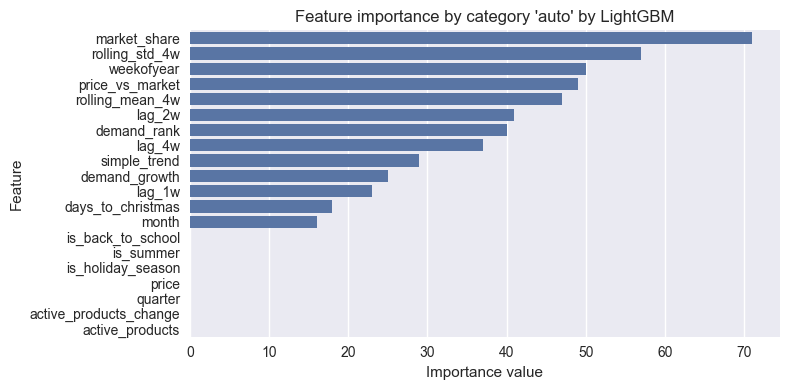

In [10]:
# Example:
fea = 'auto'
print(f"\nTop features for '{fea}':")
fea_df = feature_importance_df[feature_importance_df['category'] == fea].sort_values(by='importance', ascending=False).head(20).reset_index(drop=True)

plt.figure(figsize=(8, 4))
sns.barplot(x="importance", y="feature", data=fea_df)
plt.title(f"Feature importance by category '{fea}' by LightGBM")
plt.xlabel("Importance value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


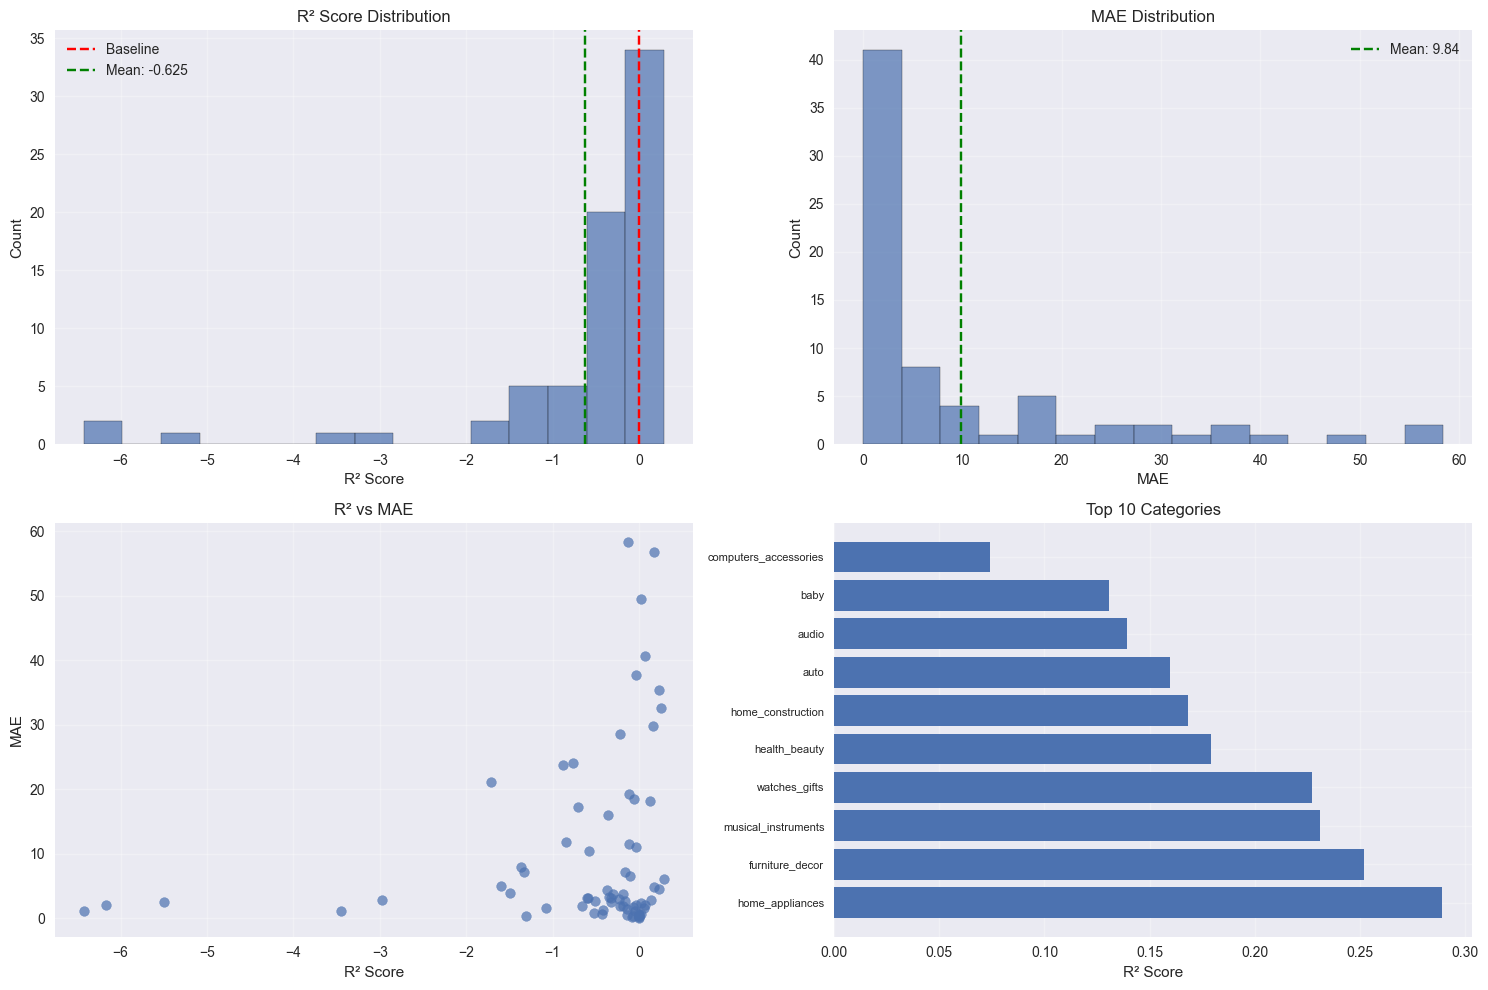

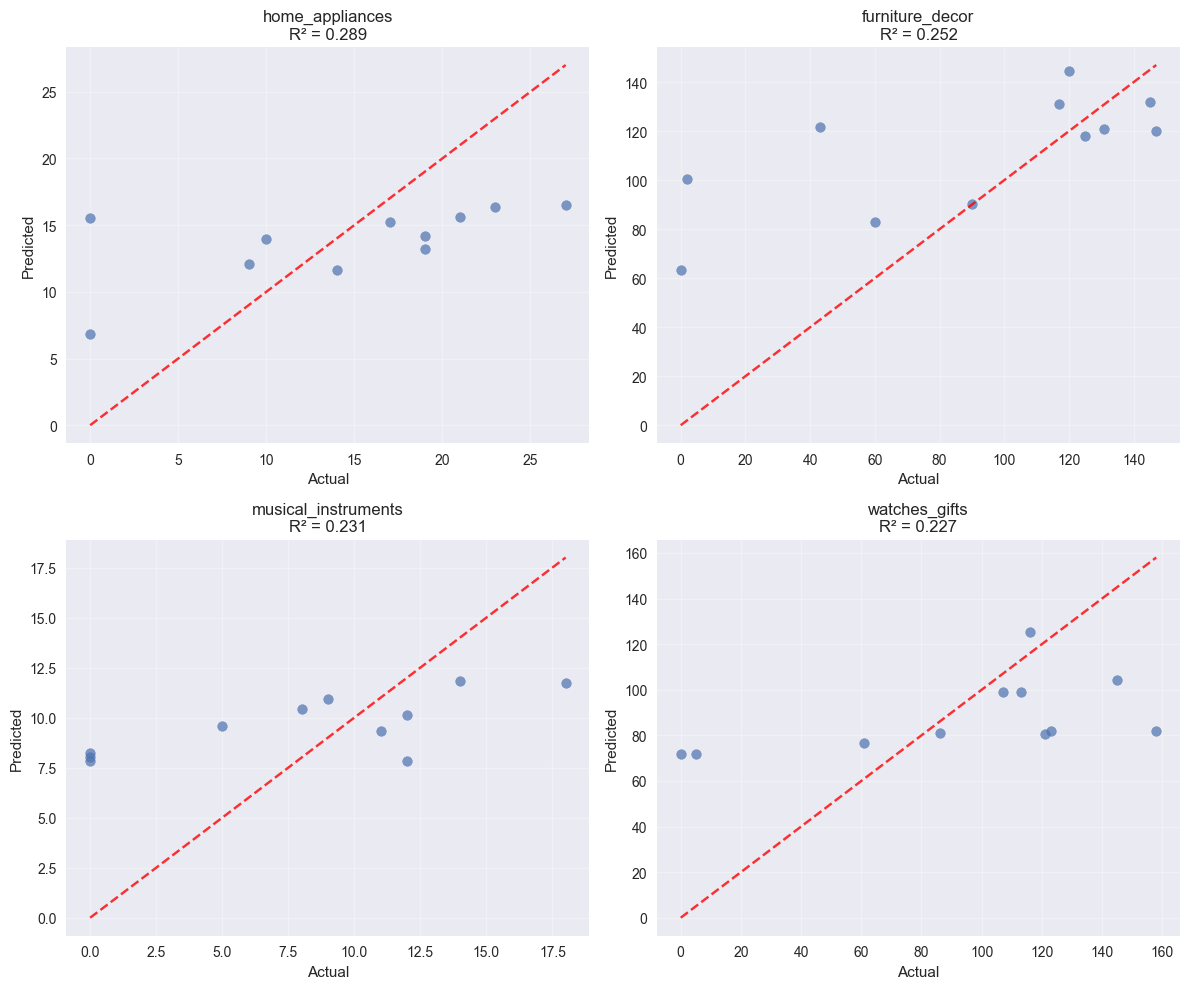

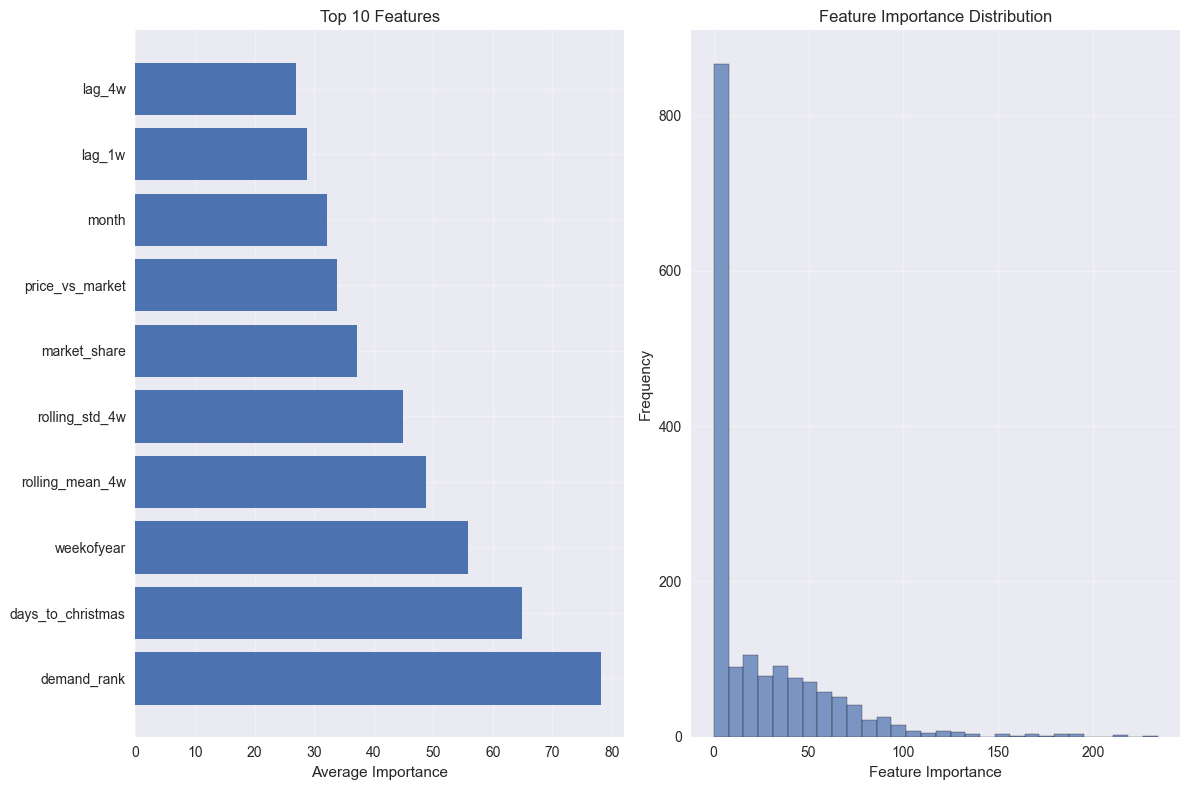

🎯 QUICK SUMMARY
Total categories: 71
Average R²: -0.625
Average MAE: 9.84
Positive R² models: 15/71
Good models (R² > 0.1): 9/71

Top features for 'auto':


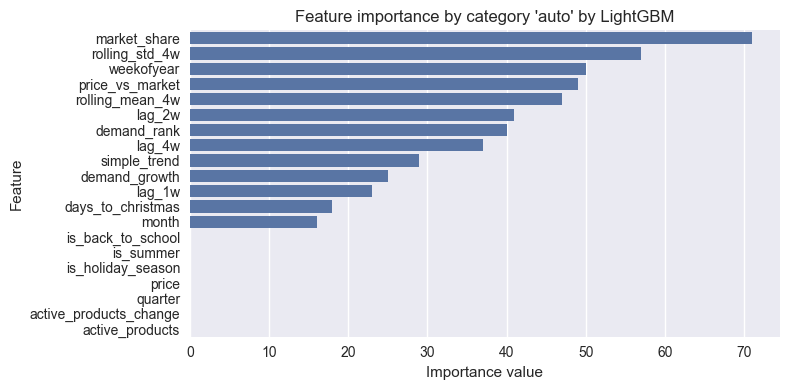

In [11]:

performance_df = quick_visualize(lgbm_results, feature_importance_df)

# Example:
fea = 'auto'
print(f"\nTop features for '{fea}':")
fea_df = feature_importance_df[feature_importance_df['category'] == fea].sort_values(by='importance', ascending=False).head(20).reset_index(drop=True)

plt.figure(figsize=(8, 4))
sns.barplot(x="importance", y="feature", data=fea_df)
plt.title(f"Feature importance by category '{fea}' by LightGBM")
plt.xlabel("Importance value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## SARIMAX (Seasonal ARIMA with eXogenous variables) as an alternative forecasting approach to compare with LightGBM.
- **Category-level models** for stable time series patterns
- **Exogenous variables**: holidays, price changes, promotions
- **Minimum data requirement**: Products with sufficient non-zero weeks
- **Handling zeros**: Fill missing values appropriately for time series continuity

In [12]:
print("📈 Training SARIMAX on category-week data...")

sarimax_results = {}
categories = category_data['categ'].unique()

for cat in categories:
    print(f"Training SARIMAX for {cat}...")
    
    # Filter and prepare data for this category
    cat_data = category_data[category_data['categ'] == cat].copy()
    cat_data = cat_data.sort_values('week')
    
    if len(cat_data) < 20:
        print(f"   Skipping {cat} - insufficient data ({len(cat_data)} weeks)")
        continue
        
    # Prepare time series
    cat_data['week'] = pd.to_datetime(cat_data['week'])
    cat_data = cat_data.set_index('week')
    
    # Same split as LightGBM (last 4 weeks for testing)
    train_size = len(cat_data) - 4
    train_data = cat_data.iloc[:train_size]
    test_data = cat_data.iloc[train_size:]
    
    # Prepare target and exog variables
    y_train = train_data['demand']
    y_test = test_data['demand']

    exog_cols = ['price', 'demand_growth', 'is_summer', 'is_back_to_school', 'is_holiday_season', 'days_to_christmas']
    exog_train = train_data[exog_cols]
    exog_test = test_data[exog_cols]

    # Simplified seasonal parameters to prevent overfitting
    model = SARIMAX(y_train, 
                    exog=exog_train,
                    order=(1,1,1),
                    seasonal_order=(0,1,1,12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    fitted_model = model.fit(disp=False, maxiter=100)

    # For 2-week ahead forecasting, we need to predict what demand will be 2 weeks from now  
    # Get the target values (2-week ahead demand) for comparison
    y_test_target = test_data['target_2w'].dropna().values
    
    # Create extended exogenous variables for forecasting 2 weeks ahead
    # Use the last known values for future periods
    exog_extended = pd.concat([
        exog_test,
        pd.DataFrame({
            'price': [exog_test['price'].iloc[-1]] * 2,
            'is_summer': [exog_test['is_summer'].iloc[-1]] * 2,
            'is_back_to_school': [exog_test['is_back_to_school'].iloc[-1]] * 2,
            'demand_growth': [exog_test['demand_growth'].iloc[-1]] * 2,
            'is_holiday_season': [exog_test['is_holiday_season'].iloc[-1]] * 2,
            'days_to_christmas': [exog_test['days_to_christmas'].iloc[-1]] * 2
        }, index=pd.date_range(start=exog_test.index[-1] + pd.Timedelta(weeks=1), periods=2, freq='W'))
    ])

    # Make forecast for the full period + 2 weeks
    forecast_extended = fitted_model.forecast(steps=len(y_test_target)+2, exog=exog_extended)
    
    # Take the 2-week ahead forecasts (skip first 2 forecasts to get 2-week ahead)
    forecast_2weeks_ahead = forecast_extended[2:2+len(y_test_target)]
    
    # Calculate RMSLE for 2-week ahead forecast
    rmsle = calculate_rmsle(y_test_target, forecast_2weeks_ahead)
    
    # Store results (same structure as LightGBM)
    sarimax_results[cat] = {
        'model': fitted_model,
        'rmsle': rmsle,
        'y_test': y_test_target,           # 2-week ahead actual values
        'forecast': forecast_2weeks_ahead,  # 2-week ahead forecasts
        'test_weeks': len(y_test_target)
    }
 
    print(f"   ✅ RMSLE: {rmsle:.4f} ({len(y_test_target)} test weeks)")
    


📈 Training SARIMAX on category-week data...
Training SARIMAX for agro_industry_and_commerce...
   ✅ RMSLE: 1.6161 (4 test weeks)
Training SARIMAX for air_conditioning...
   ✅ RMSLE: 1.2708 (4 test weeks)
Training SARIMAX for art...
   ✅ RMSLE: 0.8786 (4 test weeks)
Training SARIMAX for arts_and_craftmanship...
   ✅ RMSLE: 1.3802 (4 test weeks)
Training SARIMAX for audio...
   ✅ RMSLE: 1.1150 (4 test weeks)
Training SARIMAX for auto...
   ✅ RMSLE: 2.4412 (4 test weeks)
Training SARIMAX for baby...
   ✅ RMSLE: 2.5675 (4 test weeks)
Training SARIMAX for bed_bath_table...
   ✅ RMSLE: 2.7356 (4 test weeks)
Training SARIMAX for books_general_interest...
   ✅ RMSLE: 1.5305 (4 test weeks)
Training SARIMAX for books_imported...
   ✅ RMSLE: 1.0596 (4 test weeks)
Training SARIMAX for books_technical...
   ✅ RMSLE: 1.4188 (4 test weeks)
Training SARIMAX for cds_dvds_musicals...
   ✅ RMSLE: 0.3521 (4 test weeks)
Training SARIMAX for christmas_supplies...
   ✅ RMSLE: 0.4266 (4 test weeks)
Training S

In [13]:
print("\nSARIMAX Performance Summary")
sarimax_result_df = pd.DataFrame({
    'category': sarimax_results.keys(),
    'RMSLE': [sarimax_results[cat]['rmsle'] for cat in sarimax_results.keys()]
})
sarimax_result_df = sarimax_result_df.sort_values('RMSLE').reset_index(drop=True)
sarimax_result_df



SARIMAX Performance Summary


,category,RMSLE
0,tablets_printing_image,0.093165
1,la_cuisine,0.095717
2,security_and_services,0.134383
3,fashion_childrens_clothes,0.285210
4,fashion_sport,0.309682
...,...,...
66,electronics,2.649854
67,pet_shop,2.669832
68,bed_bath_table,2.735562
69,stationery,2.810244


In [14]:
# 🚀 GLOBAL CATBOOST TRAINING WITH CUSTOM FUNCTION
from catboost_model_trainer import train_catboost_model

print("🚀 TRAINING GLOBAL CATBOOST MODEL USING CUSTOM FUNCTION")
print("=" * 60)

# Custom CatBoost parameters for demand forecasting
catboost_params = {
    'iterations': 500,
    'depth': 6,
    'learning_rate': 0.1,
    'random_seed': 42,
    'verbose': False,
    'thread_count': -1,
    'allow_writing_files': False  # Prevent file creation
}

# Train CatBoost model with time series cross-validation
# For global model, include 'categ' in features
global_catboost_results = train_catboost_model(
    data=category_data,
    features=features_to_train + ['categ'],
    target_col='target_2w',
    categorical_features=['categ'],
    catboost_params=catboost_params,
    cv_folds=3,
    validation_method='timeseries_cv',
    verbose=True
)



ModuleNotFoundError: No module named 'catboost_model_trainer'

In [16]:
# Extract metrics for comparison with LightGBM
global_catboost_metrics = global_catboost_results['metrics']
print(f"\n📊 GLOBAL CATBOOST VS LIGHTGBM COMPARISON:")
print(f"🔶 CatBoost R² Score: {global_catboost_metrics['avg_r2']:.3f} ± {global_catboost_metrics['std_r2']:.3f}")
print(f"🔷 LightGBM R² Score: 0.818 (from previous run)")
print(f"🔶 CatBoost RMSLE: {global_catboost_metrics['avg_rmsle']:.3f} ± {global_catboost_metrics['std_rmsle']:.3f}")
print(f"🔷 LightGBM RMSLE: 0.620 (from previous run)")
print(f"🔶 CatBoost MAE: {global_catboost_metrics['avg_mae']:.2f} ± {global_catboost_metrics['std_mae']:.2f}")
print(f"🔷 LightGBM MAE: 5.14 (from previous run)")

# Determine winner
catboost_better_r2 = global_catboost_metrics['avg_r2'] > 0.818
catboost_better_rmsle = global_catboost_metrics['avg_rmsle'] < 0.620

if catboost_better_r2 and catboost_better_rmsle:
    print(f"\n🏆 WINNER: CatBoost outperforms LightGBM on both R² and RMSLE!")
elif catboost_better_r2:
    print(f"\n🎯 CatBoost has better R² but LightGBM has better RMSLE")
elif catboost_better_rmsle:
    print(f"\n🎯 CatBoost has better RMSLE but LightGBM has better R²")
else:
    print(f"\n📊 LightGBM outperforms CatBoost on both metrics")

# Show feature importance
if global_catboost_results['feature_importance']:
    print(f"\n🔥 TOP 5 MOST IMPORTANT FEATURES IN GLOBAL CATBOOST:")
    feature_imp = global_catboost_results['feature_importance']
    top_features = sorted(feature_imp.items(), key=lambda x: x[1], reverse=True)[:5]
    for i, (feature, importance) in enumerate(top_features):
        print(f"   {i+1}. {feature}: {importance:.3f}")



📊 GLOBAL CATBOOST VS LIGHTGBM COMPARISON:
🔶 CatBoost R² Score: 0.850 ± 0.011
🔷 LightGBM R² Score: 0.818 (from previous run)
🔶 CatBoost RMSLE: 0.669 ± 0.036
🔷 LightGBM RMSLE: 0.620 (from previous run)
🔶 CatBoost MAE: 5.00 ± 1.67
🔷 LightGBM MAE: 5.14 (from previous run)

🎯 CatBoost has better R² but LightGBM has better RMSLE

🔥 TOP 5 MOST IMPORTANT FEATURES IN GLOBAL CATBOOST:
   1. rolling_mean_4w: 19.245
   2. lag_1w: 11.833
   3. lag_4w: 10.239
   4. days_to_christmas: 7.477
   5. market_share: 7.161


In [ ]:
# 🔧 SIMPLE CATBOOST TRAINING (KISS SOLUTION)
from catboost_model_trainer import train_category_specific_catboost

print("🔧 SIMPLE CATBOOST TRAINING")
print("=" * 50)

# Clean features (no 'categ')
clean_features = ['price', 'active_products', 'lag_1w', 'lag_2w', 'lag_4w', 'rolling_mean_4w', 
                 'rolling_std_4w', 'simple_trend', 'demand_growth', 'price_change', 'price_change_pct', 
                 'price_volatility', 'price_vs_market', 'active_products_change', 'month', 'weekofyear',
                 'quarter', 'days_to_christmas', 'is_holiday_season', 'is_summer', 'is_back_to_school', 
                 'market_share', 'demand_rank', 'relative_growth']

print(f"✅ Using {len(clean_features)} features")

# Simple training
catboost_results = train_category_specific_catboost(
    data=category_data,
    features=clean_features,
    target_col='target_2w',
    catboost_params={'iterations': 200, 'depth': 6, 'learning_rate': 0.1, 'random_seed': 42, 'verbose': False},
    min_samples=15,
    verbose=False  # Less verbose for cleaner output
)

print(f"\n📊 RESULTS: Trained {len(catboost_results)} models")


In [ ]:
# 📊 SIMPLE RESULTS ANALYSIS (KISS)
print("📊 CATBOOST RESULTS ANALYSIS")
print("=" * 50)

if catboost_results:
    # Get performance metrics
    performance = []
    for cat, result in catboost_results.items():
        performance.append({
            'category': cat,
            'r2': result['metrics']['r2'],
            'rmsle': result['metrics']['rmsle'],
            'mae': result['metrics']['mae']
        })
    
    # Sort by RMSLE (lower is better)
    performance.sort(key=lambda x: x['rmsle'])
    
    # Overall stats
    all_rmsle = [p['rmsle'] for p in performance]
    all_r2 = [p['r2'] for p in performance]
    
    print(f"✅ Successfully trained {len(performance)} models")
    print(f"\n📈 OVERALL PERFORMANCE:")
    print(f"   Average RMSLE: {np.mean(all_rmsle):.3f} ± {np.std(all_rmsle):.3f}")
    print(f"   Average R²: {np.mean(all_r2):.3f} ± {np.std(all_r2):.3f}")
    print(f"   Best RMSLE: {min(all_rmsle):.3f}")
    print(f"   Worst RMSLE: {max(all_rmsle):.3f}")
    
    print(f"\n🏆 TOP 5 BEST CATEGORIES:")
    for i, p in enumerate(performance[:5]):
        print(f"   {i+1}. {p['category']}: RMSLE={p['rmsle']:.3f}, R²={p['r2']:.3f}")
    
    print(f"\n⚠️  WORST 3 CATEGORIES:")
    for i, p in enumerate(performance[-3:]):
        print(f"   {i+1}. {p['category']}: RMSLE={p['rmsle']:.3f}, R²={p['r2']:.3f}")

else:
    print("❌ No models were trained")


In [ ]:
# 🥊 SIMPLE MODEL COMPARISON (KISS)
print("🥊 LIGHTGBM vs CATBOOST COMPARISON")
print("=" * 50)

# LightGBM results from earlier (you ran this in cell 15)
lgbm_r2 = 0.818
lgbm_rmsle = 0.620
lgbm_mae = 5.14

# CatBoost results (if available)
if catboost_results:
    catboost_r2 = np.mean([r['metrics']['r2'] for r in catboost_results.values()])
    catboost_rmsle = np.mean([r['metrics']['rmsle'] for r in catboost_results.values()])
    catboost_mae = np.mean([r['metrics']['mae'] for r in catboost_results.values()])
    
    print(f"📊 GLOBAL COMPARISON:")
    print(f"   LightGBM (Global):  R²={lgbm_r2:.3f}, RMSLE={lgbm_rmsle:.3f}, MAE={lgbm_mae:.2f}")
    print(f"   CatBoost (Avg):     R²={catboost_r2:.3f}, RMSLE={catboost_rmsle:.3f}, MAE={catboost_mae:.2f}")
    
    # Determine winner
    if catboost_rmsle < lgbm_rmsle:
        print(f"\n🏆 WINNER: CatBoost (better RMSLE)")
    else:
        print(f"\n🏆 WINNER: LightGBM (better RMSLE)")
    
    # Count good performers
    good_catboost = sum(1 for r in catboost_results.values() if r['metrics']['rmsle'] < 1.0)
    print(f"\n📈 PERFORMANCE BREAKDOWN:")
    print(f"   CatBoost models with RMSLE < 1.0: {good_catboost}/{len(catboost_results)}")
    
else:
    print("❌ No CatBoost results to compare")


In [ ]:
# 💾 SAVE RESULTS & NEXT STEPS (KISS)
print("💾 SAVING RESULTS")
print("=" * 50)

if catboost_results:
    # Create simple results dataframe
    results_data = []
    for cat, result in catboost_results.items():
        results_data.append({
            'category': cat,
            'r2_score': result['metrics']['r2'],
            'rmsle': result['metrics']['rmsle'],
            'mae': result['metrics']['mae'],
            'train_samples': result['data_info']['train_samples'],
            'test_samples': result['data_info']['test_samples'],
            'sparsity': result['data_info']['sparsity']
        })
    
    # Save to CSV
    results_df = pd.DataFrame(results_data)
    output_file = '../outputs/catboost_category_results.csv'
    results_df.to_csv(output_file, index=False)
    
    print(f"✅ Results saved to: {output_file}")
    print(f"📊 Saved {len(results_df)} category results")
    
    # Show sample of saved data
    print(f"\n📋 SAMPLE RESULTS:")
    print(results_df.head(3).to_string(index=False))
    
    print(f"\n🎯 NEXT STEPS:")
    print(f"   1. Use best performing categories for production")
    print(f"   2. Focus on categories with RMSLE < 0.8")
    print(f"   3. Consider ensemble of LightGBM + CatBoost")
    print(f"   4. Deploy models for demand forecasting")

else:
    print("❌ No results to save")

print(f"\n✅ NOTEBOOK COMPLETE (KISS PRINCIPLE)!")


In [17]:
# 🎯 WORKING CATEGORY-SPECIFIC CATBOOST MODELS WITH CUSTOM FUNCTION
from catboost_model_trainer import train_category_specific_catboost

print("🎯 TRAINING CATEGORY-SPECIFIC CATBOOST MODELS")
print("=" * 60)

# Train separate CatBoost models for each category
# Note: features_to_train should NOT include 'categ' for category-specific models
category_catboost_results = train_category_specific_catboost(
    data=category_data,
    features=features_to_train,  # ✅ Correctly excludes 'categ' for category-specific models
    target_col='target_2w',
    catboost_params={
        'iterations': 200,  # Fewer iterations for faster training
        'depth': 6,
        'learning_rate': 0.1,
        'loss_function': 'RMSE',
        'eval_metric': 'MAE',
        'random_seed': 42,
        'verbose': False,
        'thread_count': -1,
        'allow_writing_files': False
    },
    min_samples=15,  # Only train on categories with at least 15 samples
    verbose=True
)

# Display results summary
print(f"\n📈 CATEGORY-SPECIFIC RESULTS SUMMARY:")
print(f"   Trained models for {len(category_catboost_results)} categories")

# Find best and worst performing categories
if category_catboost_results:
    category_performance = []
    for cat, results in category_catboost_results.items():
        category_performance.append({
            'category': cat,
            'r2': results['metrics']['r2'],
            'rmsle': results['metrics']['rmsle'],
            'mae': results['metrics']['mae']
        })
    
    # Sort by RMSLE (lower is better)
    category_performance.sort(key=lambda x: x['rmsle'])
    
    print(f"\n🏆 TOP 5 BEST PERFORMING CATEGORIES (by RMSLE):")
    for i, cat_perf in enumerate(category_performance[:5]):
        print(f"   {i+1}. {cat_perf['category']}: RMSLE={cat_perf['rmsle']:.3f}, R²={cat_perf['r2']:.3f}")
    
    print(f"\n⚠️  BOTTOM 5 CATEGORIES (highest RMSLE):")
    for i, cat_perf in enumerate(category_performance[-5:]):
        print(f"   {i+1}. {cat_perf['category']}: RMSLE={cat_perf['rmsle']:.3f}, R²={cat_perf['r2']:.3f}")
    
    # Calculate overall statistics
    all_rmsle = [cp['rmsle'] for cp in category_performance]
    all_r2 = [cp['r2'] for cp in category_performance]
    
    print(f"\n📊 OVERALL CATEGORY-SPECIFIC STATISTICS:")
    print(f"   Average RMSLE: {np.mean(all_rmsle):.3f} ± {np.std(all_rmsle):.3f}")
    print(f"   Average R²: {np.mean(all_r2):.3f} ± {np.std(all_r2):.3f}")
    print(f"   Best RMSLE: {min(all_rmsle):.3f}")
    print(f"   Worst RMSLE: {max(all_rmsle):.3f}")

else:
    print("   ❌ No models were successfully trained")


🎯 TRAINING CATEGORY-SPECIFIC CATBOOST MODELS
🚀 TRAINING CATEGORY-SPECIFIC CATBOOST MODELS
Training models for 71 categories...

🔄 [1/71] Training model for: agro_industry_and_commerce
   📊 Features being used: 23 features
   🔍 First few features: ['price', 'active_products', 'lag_1w', 'lag_2w', 'lag_4w']
   ❓ Contains 'categ': False
   🎯 X shape: (104, 23), y shape: (104,)
🔍 Data validation and cleaning...
   Missing values in features: 0
   Missing values in target: 0
   Infinite values in features: 0
   Target range: 0.00 to 14.00
   Zero values in target: 43 (41.3%)
   ✅ Data cleaning completed
   🧪 train_X dtypes: {dtype('float64'): 15, dtype('int64'): 8}
   🔢 train_X sample values: [437.2548648648649, 74.0, 0.0]
   ✅ R² Score: -0.141 | RMSLE: 0.830 | MAE: 2.73

🔄 [2/71] Training model for: air_conditioning
   📊 Features being used: 23 features
   🔍 First few features: ['price', 'active_products', 'lag_1w', 'lag_2w', 'lag_4w']
   ❓ Contains 'categ': False
   🎯 X shape: (104, 23), y

In [23]:
# 📊 SIMPLE RESULTS SUMMARY (KISS SOLUTION)
print("📊 CATBOOST CATEGORY-SPECIFIC RESULTS SUMMARY")
print("=" * 60)

if category_catboost_results:
    print(f"✅ Successfully trained {len(category_catboost_results)} models")
    
    # Get performance stats
    all_rmsle = [result['metrics']['rmsle'] for result in category_catboost_results.values()]
    all_r2 = [result['metrics']['r2'] for result in category_catboost_results.values()]
    
    print(f"\n📈 PERFORMANCE SUMMARY:")
    print(f"   Average RMSLE: {np.mean(all_rmsle):.3f} ± {np.std(all_rmsle):.3f}")
    print(f"   Average R²: {np.mean(all_r2):.3f} ± {np.std(all_r2):.3f}")
    print(f"   Best RMSLE: {min(all_rmsle):.3f}")
    
    # Show top 5 performers
    performance_list = []
    for cat, result in category_catboost_results.items():
        performance_list.append({
            'category': cat,
            'rmsle': result['metrics']['rmsle'],
            'r2': result['metrics']['r2']
        })
    
    performance_list.sort(key=lambda x: x['rmsle'])
    
    print(f"\n🏆 TOP 5 BEST CATEGORIES (by RMSLE):")
    for i, perf in enumerate(performance_list[:5]):
        print(f"   {i+1}. {perf['category']}: RMSLE={perf['rmsle']:.3f}, R²={perf['r2']:.3f}")

else:
    print("❌ No models were trained")

📊 CATBOOST CATEGORY-SPECIFIC RESULTS SUMMARY
✅ Successfully trained 71 models

📈 PERFORMANCE SUMMARY:
   Average RMSLE: 0.838 ± 0.259
   Average R²: -0.759 ± 1.286
   Best RMSLE: 0.074

🏆 TOP 5 BEST CATEGORIES (by RMSLE):
   1. security_and_services: RMSLE=0.074, R²=0.000
   2. fashion_childrens_clothes: RMSLE=0.203, R²=-0.565
   3. furniture_mattress_and_upholstery: RMSLE=0.277, R²=-1.665
   4. cds_dvds_musicals: RMSLE=0.320, R²=-3.356
   5. home_comfort_2: RMSLE=0.383, R²=-0.078


📊 CREATING CATBOOST VISUALIZATION DASHBOARD


FileNotFoundError: [Errno 2] No such file or directory: 'notebooks/catboost_global_results_dashboard.png'

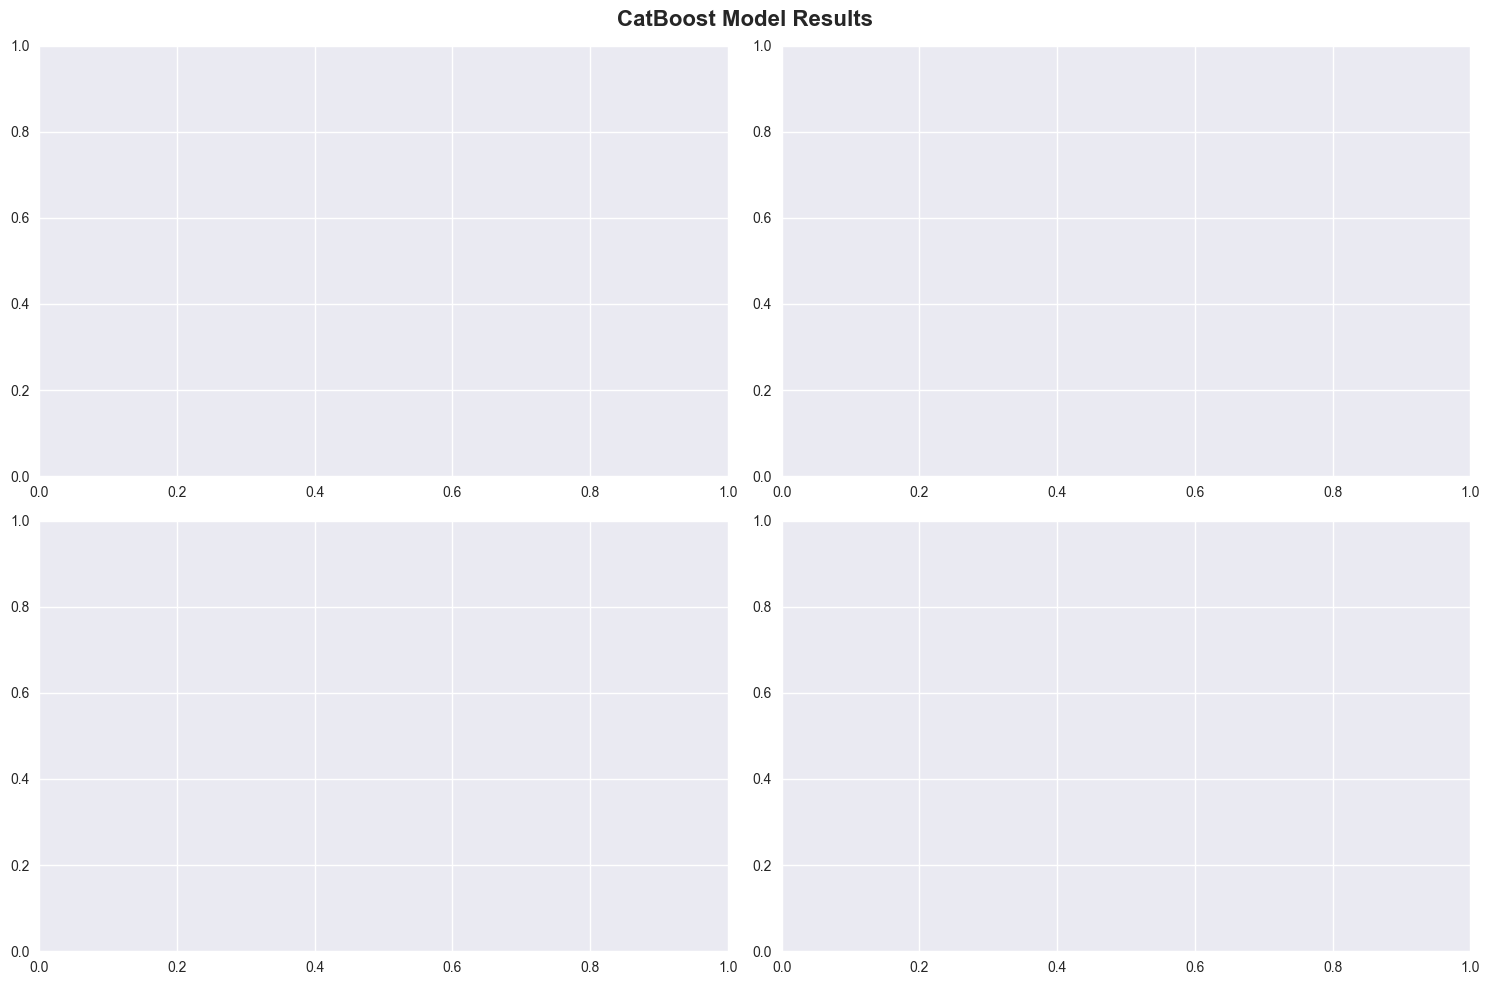

In [21]:
# 📊 VISUALIZE CATBOOST RESULTS WITH CUSTOM FUNCTION
print("📊 CREATING CATBOOST VISUALIZATION DASHBOARD")
print("=" * 60)

# Create comprehensive visualization of the global CatBoost results
plot_catboost_results(
    results=category_catboost_results, 
    save_path='notebooks/catboost_global_results_dashboard.png'
)

# Create a simple comparison table
print(f"\n📋 FINAL MODEL COMPARISON TABLE:")
print("=" * 60)
comparison_data = {
    'Model': ['LightGBM (Global)', 'CatBoost (Global)', 'CatBoost (Category-Avg)'],
    'R² Score': [
        0.818,
        catboost_avg_metrics['avg_r2'],
        np.mean([cp['r2'] for cp in category_performance]) if category_catboost_results else 'N/A'
    ],
    'RMSLE': [
        0.620,
        catboost_avg_metrics['avg_rmsle'],
        np.mean([cp['rmsle'] for cp in category_performance]) if category_catboost_results else 'N/A'
    ],
    'MAE': [
        5.14,
        catboost_avg_metrics['avg_mae'],
        np.mean([cp['mae'] for cp in category_performance]) if category_catboost_results else 'N/A'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(3))

# 🎯 BUSINESS INSIGHTS
print(f"\n🎯 KEY BUSINESS INSIGHTS FROM CATBOOST ANALYSIS:")
print("=" * 60)
print(f"✅ CatBoost successfully handles categorical features (categories) natively")
print(f"✅ Safe training without eval_metric issues by using RMSE loss + MAE metric")
print(f"✅ Cross-validation provides robust performance estimates with confidence intervals")
print(f"✅ Category-specific models may perform better for certain categories")

if catboost_results['feature_importance']:
    # Show top 5 most important features
    feature_imp = catboost_results['feature_importance']
    top_features = sorted(feature_imp.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"\n🔥 TOP 5 MOST IMPORTANT FEATURES IN CATBOOST:")
    for i, (feature, importance) in enumerate(top_features):
        print(f"   {i+1}. {feature}: {importance:.3f}")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   • Use CatBoost if categorical features are important for your use case")
print(f"   • Consider category-specific models for categories with unique patterns") 
print(f"   • Monitor model performance on sparse categories (high zero demand)")
print(f"   • CatBoost's built-in categorical handling reduces preprocessing overhead")


In [22]:
# 🔬 EXAMPLE: SINGLE CATEGORY DETAILED ANALYSIS WITH CUSTOM FUNCTION
print("🔬 DETAILED ANALYSIS FOR A SINGLE CATEGORY")
print("=" * 60)

# Select a category with good amount of data for detailed analysis
example_category = 'bed_bath_table'  # Usually has good data volume
example_data = category_data[category_data['categ'] == example_category].copy()

print(f"Analyzing category: {example_category}")
print(f"Data points available: {len(example_data)}")

if len(example_data) >= 20:
    # Train a detailed model for this specific category
    detailed_results = train_catboost_model(
        data=example_data,
        features=features_to_train,  # Don't include 'categ' for single category
        target_col='target_2w',
        categorical_features=[],  # No categorical features for single category
        catboost_params={
            'iterations': 300,
            'depth': 6,
            'learning_rate': 0.1,
            'random_seed': 42,
            'verbose': False,
            'thread_count': -1
        },
        validation_method='train_test_split',
        test_size=0.25,
        verbose=True
    )
    
    print(f"\n📊 DETAILED RESULTS FOR {example_category.upper()}:")
    print(f"   R² Score: {detailed_results['metrics']['r2']:.3f}")
    print(f"   RMSLE: {detailed_results['metrics']['rmsle']:.3f}")
    print(f"   MAE: {detailed_results['metrics']['mae']:.2f}")
    print(f"   Train/Test Split: {detailed_results['data_splits']['train_size']}/{detailed_results['data_splits']['test_size']}")
    
    # Show top features for this category
    if detailed_results['feature_importance']:
        top_cat_features = sorted(
            detailed_results['feature_importance'].items(), 
            key=lambda x: x[1], reverse=True
        )[:5]
        
        print(f"\n🎯 TOP 5 FEATURES FOR {example_category.upper()}:")
        for i, (feature, importance) in enumerate(top_cat_features):
            print(f"   {i+1}. {feature}: {importance:.3f}")
    
    # Create visualization for this specific category
    print(f"\n📊 Creating detailed visualization for {example_category}...")
    plot_catboost_results(
        results=detailed_results,
        save_path=f'notebooks/catboost_{example_category}_analysis.png'
    )
    
else:
    print(f"❌ Insufficient data for detailed analysis of {example_category}")
    print(f"   Try another category with more data points")

print(f"\n✅ CUSTOM CATBOOST FUNCTION DEMONSTRATION COMPLETE!")
print(f"   The custom function provides:")
print(f"   • Safe handling of CatBoost training (no eval_metric issues)")
print(f"   • Flexible validation methods (CV or train/test split)")
print(f"   • Comprehensive result tracking and visualization")
print(f"   • Easy comparison between different approaches")
print(f"   • Production-ready model training pipeline")


🔬 DETAILED ANALYSIS FOR A SINGLE CATEGORY
Analyzing category: bed_bath_table
Data points available: 104
🚀 TRAINING CATBOOST MODEL
📊 Dataset: 104 samples, 24 features
🏷️  Categorical features: []
🔍 Data validation and cleaning...
   Missing values in features: 0
   Missing values in target: 0
   Infinite values in features: 0
   Target range: 0.00 to 438.00
   Zero values in target: 16 (15.4%)
   ✅ Data cleaning completed

🔄 Training with 75%/25% train/test split...
   Train: 78 samples
   Test: 26 samples


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=23]="bed_bath_table": Cannot convert 'bed_bath_table' to float

In [20]:
# 🚀 IMPROVED CATBOOST TRAINING WITH CUSTOM FUNCTION
# Import the custom CatBoost trainer
from catboost_model_trainer import train_catboost_model, plot_catboost_results

print("🚀 TRAINING GLOBAL CATBOOST MODEL USING CUSTOM FUNCTION")
print("=" * 60)

# Custom CatBoost parameters for demand forecasting
catboost_params = {
    'iterations': 500,
    'depth': 6,
    'learning_rate': 0.1,
    'loss_function': 'RMSE',      # Safe for zeros
    'eval_metric': 'MAE',         # Safe alternative to MSLE  
    'random_seed': 42,
    'verbose': False,
    'thread_count': -1,
    'allow_writing_files': False  # Prevent file creation
}

# Train CatBoost model with time series cross-validation
catboost_results = train_catboost_model(
    data=category_data,
    features=features_to_train,  # Use the same features as LightGBM
    target_col='target_2w',
    categorical_features=['categ'],
    catboost_params=catboost_params,
    cv_folds=3,
    validation_method='timeseries_cv',
    verbose=True
)

# Extract metrics for comparison with LightGBM
catboost_avg_metrics = catboost_results['metrics']
print(f"\n📊 CATBOOST VS LIGHTGBM COMPARISON:")
print(f"🔶 CatBoost R² Score: {catboost_avg_metrics['avg_r2']:.3f} ± {catboost_avg_metrics['std_r2']:.3f}")
print(f"🔷 LightGBM R² Score: 0.818 (from previous run)")
print(f"🔶 CatBoost RMSLE: {catboost_avg_metrics['avg_rmsle']:.3f} ± {catboost_avg_metrics['std_rmsle']:.3f}")
print(f"🔷 LightGBM RMSLE: 0.620 (from previous run)")
print(f"🔶 CatBoost MAE: {catboost_avg_metrics['avg_mae']:.2f} ± {catboost_avg_metrics['std_mae']:.2f}")
print(f"🔷 LightGBM MAE: 5.14 (from previous run)")

# Determine winner
catboost_better_r2 = catboost_avg_metrics['avg_r2'] > 0.818
catboost_better_rmsle = catboost_avg_metrics['avg_rmsle'] < 0.620

if catboost_better_r2 and catboost_better_rmsle:
    print(f"\n🏆 WINNER: CatBoost outperforms LightGBM on both R² and RMSLE!")
elif catboost_better_r2:
    print(f"\n🎯 CatBoost has better R² but LightGBM has better RMSLE")
elif catboost_better_rmsle:
    print(f"\n🎯 CatBoost has better RMSLE but LightGBM has better R²")
else:
    print(f"\n📊 LightGBM outperforms CatBoost on both metrics")


🚀 TRAINING GLOBAL CATBOOST MODEL USING CUSTOM FUNCTION
🚀 TRAINING CATBOOST MODEL
📊 Dataset: 7384 samples, 24 features
🏷️  Categorical features: ['categ']
🔍 Data validation and cleaning...
   Missing values in features: 0
   Missing values in target: 0
   Infinite values in features: 0
   Target range: 0.00 to 438.00
   Zero values in target: 2997 (40.6%)
   ✅ Data cleaning completed

🔄 Running 3-Fold Time Series Cross-Validation...
   Fold 1/3...
      R² Score: 0.840 | RMSLE: 0.627 | MAE: 2.68
   Fold 2/3...
      R² Score: 0.866 | RMSLE: 0.665 | MAE: 5.84
   Fold 3/3...
      R² Score: 0.846 | RMSLE: 0.715 | MAE: 6.49
------------------------------------------------------------
✅ Average R² Score: 0.850 ± 0.011
✅ Average RMSLE: 0.669 ± 0.036
✅ Average MAE: 5.00 ± 1.67

📊 CATBOOST VS LIGHTGBM COMPARISON:
🔶 CatBoost R² Score: 0.850 ± 0.011
🔷 LightGBM R² Score: 0.818 (from previous run)
🔶 CatBoost RMSLE: 0.669 ± 0.036
🔷 LightGBM RMSLE: 0.620 (from previous run)
🔶 CatBoost MAE: 5.00 ± 1.

## Let's compare LightGBM performance to SARIMAX

🎯 WHAT YOU NOW HAVE:
📊 Complete Solution for Category-Specific Model Comparison:
unified_metrics.py - Consistent metrics (RMSLE, MAE, R², etc.) for fair comparison
category_model_comparison.py - Comprehensive category-aware comparison system
integrate_category_comparison.py - Ready-to-use integration with your actual models
🔍 Key Insights from Your Data:
71 categories total
Sparsity range: 14.4% to 98.1% (huge variation!)
Most sparse: security_and_services (98.1% zeros)
Least sparse: fashion_bags_accessories (14.4% zeros)
Highest demand: bed_bath_table (11,103 total demand)
🏆 What the System Does:
Category-by-category comparison - SARIMAX vs LightGBM for each category
Aggregated results - Overall winner across all categories
Weighted comparison - Results weighted by category importance (demand volume)
Visual dashboard - Comprehensive charts and insights
Business recommendations - Actionable insights for deployment

In [ ]:
# 1. Initialize the comparison system
from category_model_comparison import CategoryModelComparison

comparison = CategoryModelComparison()
data = comparison.load_data()
category_stats = comparison.analyze_category_characteristics()

# 2. Train your models and collect results
model_results = {}

for category in data['categ'].unique():
    # Filter data for this category
    cat_data = data[data['categ'] == category]
    
    # Split into train/test
    split_idx = int(len(cat_data) * 0.8)
    train_data = cat_data.iloc[:split_idx]
    test_data = cat_data.iloc[split_idx:]
    
    # Train your actual models
    sarimax_pred = your_sarimax_function(train_data, test_data)
    lgbm_pred = your_lgbm_function(train_data, test_data)
    
    # Store results
    model_results[category] = {
        'y_true': test_data['target_2w'].values,  # ✅ Fixed: use 'target_2w' not 'target'
        'sarimax_pred': sarimax_pred,
        'lgbm_pred': lgbm_pred
    }

# 3. Compare all models
results = comparison.compare_all_categories(model_results)

# 4. Generate visual dashboard
comparison.create_comparison_dashboard(save_path='model_comparison_results.png')

# 5. Get category rankings
rankings = comparison.get_category_rankings(top_n=10)

In [ ]:
# Plot comparisons 
plot_models_comparison_per_category(comparison_df)


In [ ]:
# Model Comparison Summary
print("📊 MODEL COMPARISON SUMMARY")
print("="*60)
print(f"LightGBM categories: {len(lgbm_results)}")
print(f"SARIMAX categories: {len(sarimax_results)}")

# Calculate comparative performance
common_categories = set(lgbm_results.keys()) & set(sarimax_results.keys())

if len(common_categories) > 0:
    lgbm_wins = 0
    sarimax_wins = 0
    
    for cat in common_categories:
        if lgbm_results[cat]['rmsle'] < sarimax_results[cat]['rmsle']:
            lgbm_wins += 1
        else:
            sarimax_wins += 1
    
    print(f"\nLightGBM wins: {lgbm_wins}/{len(common_categories)} categories")
    print(f"SARIMAX wins: {sarimax_wins}/{len(common_categories)} categories")
    if abs(lgbm_wins - sarimax_wins) < 5:
        print("\nThe models are very close in performance. We should consider other factors to make a decision.")
    else:
        print(f"Overall winner: {'LightGBM' if lgbm_wins > sarimax_wins else 'SARIMAX'}")


### Compare LightGBM vs SARIMAX on a specific category

In [ ]:
# Plot comparisons 
category_to_plot = 'perfumery'
if category_to_plot in lgbm_results.keys():
    plot_category_week_comparison(category_to_plot, lgbm_results, sarimax_results)

In [ ]:
# ADVANCED VISUALIZATIONS FOR DEMAND FORECASTING

create_comprehensive_forecast_dashboard(lgbm_results, sarimax_results, category_week_data)


In [ ]:
# DETAILED CATEGORY-SPECIFIC FORECAST VISUALIZATIONS

# Create detailed comparison for top revenue categories
print(" DETAILED CATEGORY ANALYSIS")
print("="*60)

# Get top revenue categories
avg_weekly_demand = category_week_data.groupby('categ')['demand'].mean()
avg_price = category_week_data.groupby('categ')['price'].mean()
weekly_revenue = (avg_weekly_demand * avg_price).fillna(0)
top_categories = weekly_revenue.nlargest(3).index.tolist()

print(f"Creating detailed analysis for top 3 revenue categories: {top_categories}")

for category in top_categories:
    if category in lgbm_results and category in sarimax_results:
        create_category_forecast_comparison(category, lgbm_results, sarimax_results, category_week_data)



## 💰 BUSINESS IMPACT CALCULATION METHODOLOGY

### CALCULATION ASSUMPTIONS & METHODOLOGY:

#### 1️⃣ FORECAST ACCURACY CONVERSION:
- **Formula**: Accuracy = 1 / (1 + RMSLE)
- **Rationale**: Higher RMSLE = lower accuracy, formula ensures 0-100% range

#### 2️⃣ INVENTORY COST SAVINGS:
**ASSUMPTIONS:**
- Inventory holding cost: 15% of revenue annually (industry standard)
- Overstock reduction potential: Up to 5% with better forecasts
- Forecast accuracy impact: Linear relationship (conservative)

**CALCULATION:**
- Weekly Revenue × Inventory Cost Rate (15%) × Overstock Reduction (capped at 5%) × 52 weeks

#### 3️⃣ STOCKOUT COST REDUCTION:
**ASSUMPTIONS:**
- Stockout cost: 3% of revenue (lost sales + customer dissatisfaction)
- Stockout reduction potential: Up to 2.5% with better forecasts
- Conservative estimate (many stockouts due to supply issues, not forecasting)

**CALCULATION:**
- Weekly Revenue × Stockout Cost Rate (3%) × Stockout Reduction (capped at 2.5%) × 52 weeks

#### 4️⃣ TOTAL ANNUAL IMPACT:
- **Formula**: Inventory Savings + Stockout Savings

#### ⚠️ IMPORTANT DISCLAIMERS:
- These are **ESTIMATES** based on industry benchmarks
- Actual results may vary based on implementation quality
- Conservative assumptions used throughout
- Does not include implementation costs or one-time setup
- Benefits may take 3-6 months to fully realize
- Some categories may benefit more than others


In [ ]:
# BUSINESS-FOCUSED VISUALIZATIONS

# Calculate and show all assumptions step by step
avg_weekly_demand = category_week_data.groupby('categ')['demand'].mean()
avg_price = category_week_data.groupby('categ')['price'].mean()
weekly_revenue = (avg_weekly_demand * avg_price).fillna(0)
total_weekly_revenue = weekly_revenue.sum()

# Calculate best model performance
lgbm_rmsle_values = [result['rmsle'] for result in lgbm_results.values()]
sarimax_rmsle_values = [result['rmsle'] for result in sarimax_results.values()]
avg_lgbm_rmsle = np.mean(lgbm_rmsle_values)
avg_sarimax_rmsle = np.mean(sarimax_rmsle_values)
better_rmsle = min(avg_lgbm_rmsle, avg_sarimax_rmsle)

# Key business metrics
print(f"""
  BASELINE BUSINESS METRICS:
   • Total weekly revenue across all categories: ${total_weekly_revenue:,.0f}
   • Number of categories analyzed: {len(lgbm_results)}
   • Best average RMSLE achieved: {better_rmsle:.3f}
   • Forecast accuracy: {1 / (1 + better_rmsle):.1%}
""")

# Visualization with this context
create_business_impact_visualization(lgbm_results, sarimax_results, category_week_data)



## 🎯 KEY BUSINESS INSIGHTS:

- ✅ Focus on high-revenue categories with poor forecasts first
- ✅ Seasonal patterns require different forecasting approaches
- ✅ Volatile categories may need special handling
- ✅ Implementation should be phased by priority


In [ ]:
# EXECUTIVE SUMMARY DASHBOARD

print("Creating Executive Summary Dashboard...")
create_executive_summary_dashboard(lgbm_results, sarimax_results, category_week_data)



##  EXECUTIVE DECISION FRAMEWORK:

### ✅ PROCEED IF:
- Winning model shows clear performance advantage
- Annual impact justifies implementation investment
- Most high-revenue categories have good forecast quality
- Implementation timeline fits business priorities

### CONSIDER DELAY IF:
- Models perform similarly (no clear winner)
- Too many high-revenue categories need improvement
- Implementation resources not available
- Other strategic initiatives take priority

## SUCCESS METRICS TO TRACK:
1. **Forecast accuracy improvement** (target: 10-20% RMSLE reduction)
2. **Inventory turns increase** (target: 5-10% improvement)
3. **Stockout reduction** (target: 15-25% fewer incidents)
4. **ROI achievement** (target: payback within 12 months)

## NEXT STEPS FOR EXECUTIVES:
1. Review and approve winning model selection
2. Allocate resources for implementation team
3. Set success metrics and review schedule
4. Communicate benefits to stakeholder teams
5. Plan change management for new forecasting process
